# Autoencoding beyond pixels using a learned similarity metric
* paper: [Autoencoding beyond pixels using a learned similarity metric](https://arxiv.org/pdf/1512.09300.pdf)

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim

import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader, Subset, Dataset

from tqdm import tqdm
from typing import List,Tuple


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
ts = [T.ToTensor(), T.Resize((32, 32)), T.Normalize([0.5], [0.5])]
mnist_train = datasets.MNIST(
    root='dat',
    train=True,
    download=True,
    transform=T.Compose(ts)
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dat/MNIST/raw/train-images-idx3-ubyte.gz to dat/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dat/MNIST/raw/train-labels-idx1-ubyte.gz to dat/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dat/MNIST/raw/t10k-images-idx3-ubyte.gz to dat/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dat/MNIST/raw/t10k-labels-idx1-ubyte.gz to dat/MNIST/raw



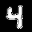

In [ ]:
fixed = mnist_train[58][0]

display(T.ToPILImage()(fixed))

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 64, 5, 2, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 5, 2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 5, 2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # self.mean = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(4*4*256, 2048),
        #     nn.BatchNorm1d(2048),
        #     nn.ReLU(),
        # )

        # self.logvar = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(4*4*256, 2048),
        #     nn.BatchNorm1d(2048),
        #     nn.ReLU(),
        # )

        self.mean = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*256, 2048),
        )

        self.logvar = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*256, 2048),
            nn.Tanh(),
        )

    def forward(self, X):
        out = self.enc(X)
        mean = self.mean(out)
        logvar = self.logvar(out)
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.dec = nn.Sequential(
            nn.Linear(2048, 4*4*256),
            nn.BatchNorm1d(4*4*256),
            nn.ReLU(),

            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 256, 5, 2, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 5, 2, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 32, 5, 2, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 1, 5, 1, 2),
            nn.Tanh(),
        )

    def forward(self, Z):
        out = self.dec(Z)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1, 2),
            nn.ReLU(),
        )

        self.downsample = nn.Sequential(
            nn.Conv2d(32, 128, 5, 2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 5, 2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 5, 2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, X):
        out = self.conv(X)
        downsample = self.downsample(out)
        out = self.flatten(downsample)
        return out, downsample

In [ ]:
def kl_loss(mean, logvar):
    return -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

def get_sample(mean, logvar):
    var = torch.exp(logvar/2).to(DEVICE)
    e = torch.randn_like(mean).to(DEVICE)
    return mean + var*e

def train(enc, dec, dis, opt_enc, opt_dec, opt_dis, dl, epochs):
    bce = nn.BCELoss()
    mse = nn.MSELoss()

    for i in tqdm(range(epochs)):
        enc.train()
        dec.train()
        dis.train()
        
        for j, (X, _) in enumerate(dl):
            
            X = X.to(DEVICE)
            
            # train encoder
            opt_enc.zero_grad()
            mean, logvar = enc(X)
            l_prior = kl_loss(mean, logvar)
            loss_kl.append(l_prior.detach().cpu())
            
            # train decoder
            opt_dec.zero_grad()
            Z = get_sample(mean, logvar)
            X_dec = dec(Z)
            Zp = torch.randn_like(Z).to(DEVICE)
            Xp = dec(Zp)

            # train discriminator
            opt_dis.zero_grad()
            dis_X, ds_X = dis(X)
            dis_X_dec, _ = dis(X_dec.detach())
            dis_Xp, _ = dis(Xp.detach())

            real = torch.full_like(dis_X, 1)
            fake = torch.full_like(dis_X, 0)
            l_dis = bce(dis_X, real) + bce(dis_X_dec, fake) + bce(dis_Xp, fake)
            l_dis.backward(retain_graph=True)
            loss_dis.append(l_dis.detach().cpu())


            # train encoder/decoder
            dis_X_dec, ds_X_dec = dis(X_dec)
            dis_Xp, _ = dis(Xp)
            l_gan = bce(dis_X_dec, real) + bce(dis_Xp, real)
            
            l_like = mse(ds_X_dec, ds_X)
            l_enc = l_prior + 100*l_like
            l_enc.backward(retain_graph=True)
            
            l_dec = 1e-6*l_like + l_gan
            l_dec.backward(retain_graph=True)
            
            loss_like.append(l_like.detach().cpu())
            

            loss_enc.append((l_prior + l_like).detach().cpu())
            loss_dec.append(l_dec.detach().cpu())


            opt_dec.step()
            opt_enc.step()
            opt_dis.step()
        # print updates
        if i % 2 == 0:
            to_img = T.ToPILImage()
            enc.eval()
            dec.eval()
            dis.eval()
            mean, logvar = enc(fixed.to(DEVICE).view(-1, 1, 32, 32))
            z = get_sample(mean, logvar)
            out = dec(z)
            print()
            print(dis(out)[0].item())
            display(to_img(out.view(-1, 32, 32)))




In [ ]:
loss_real = []
loss_fake_dec = []
loss_fake_p = []
loss_kl = []
loss_like = []

loss_enc = []
loss_dec = []
loss_dis = []

enc = Encoder().to(DEVICE)
dec = Decoder().to(DEVICE)
dis = Discriminator().to(DEVICE)

opt_enc = optim.Adam(enc.parameters(), lr=2e-4, betas=(0.5,.999))
opt_dec = optim.Adam(dec.parameters(), lr=2e-4, betas=(0.5,.999))
opt_dis = optim.Adam(dis.parameters(), lr=2e-4, betas=(0.5,.999))

# dl = DataLoader(Subset(mnist_train, range(500)), batch_size=64, shuffle=True)
dl = DataLoader(Subset(mnist_train, range(5000)), batch_size=64, shuffle=True)
# dl = DataLoader(mnist_train, batch_size=64, shuffle=True)

  0%|          | 0/30 [00:00<?, ?it/s]


0.8792425394058228


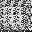

  7%|▋         | 2/30 [00:35<08:18, 17.80s/it]


1.0


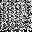

 13%|█▎        | 4/30 [01:11<07:48, 18.01s/it]


0.9910022616386414


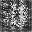

 20%|██        | 6/30 [01:48<07:16, 18.17s/it]


1.0


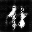

 27%|██▋       | 8/30 [02:25<06:43, 18.35s/it]


1.0


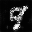

 33%|███▎      | 10/30 [03:02<06:09, 18.48s/it]


0.00021276233019307256


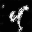

 40%|████      | 12/30 [03:39<05:34, 18.61s/it]


6.850445544159811e-09


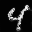

 47%|████▋     | 14/30 [04:17<04:59, 18.72s/it]


1.0


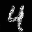

 53%|█████▎    | 16/30 [04:55<04:23, 18.81s/it]


1.0


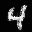

 60%|██████    | 18/30 [05:33<03:46, 18.91s/it]


1.0


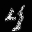

 67%|██████▋   | 20/30 [06:11<03:09, 18.99s/it]


0.9998070597648621


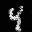

 73%|███████▎  | 22/30 [06:49<02:32, 19.02s/it]


0.04833712428808212


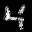

 80%|████████  | 24/30 [07:27<01:54, 19.05s/it]


1.0


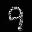

 87%|████████▋ | 26/30 [08:05<01:16, 19.04s/it]


0.9997115731239319


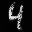

 93%|█████████▎| 28/30 [08:43<00:38, 19.04s/it]


1.0


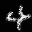

100%|██████████| 30/30 [09:22<00:00, 18.73s/it]


In [ ]:
train(
    enc,
    dec,
    dis,
    opt_enc,
    opt_dec,
    opt_dis,
    dl,
    30
)

In [ ]:
torch.save(enc.state_dict(), 'encoder.pth')
torch.save(dec.state_dict(), 'decoder.pth')
torch.save(dis.state_dict(), 'discriminator.pth')

In [ ]:
!tar cfz model.tar.gz decoder.pth discriminator.pth encoder.pth

In [ ]:
!du -h discriminator.pth

18M	discriminator.pth



0.964182436466217


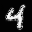

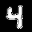

In [ ]:
to_img = T.ToPILImage()
enc.eval()
dec.eval()
dis.eval()

# fixed
mean, logvar = enc(fixed.to(DEVICE).view(-1, 1, 32, 32))
z = get_sample(mean, logvar)
out = dec(z)
print()
print(dis(out)[0].item())
display(to_img(out.view(-1, 32, 32)))

# actual
display(to_img(fixed))


0.9438654780387878


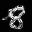

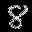

In [ ]:
from random import randint

to_img = T.ToPILImage()
enc.eval()
dec.eval()
dis.eval()

test = mnist_train[randint(0,len(mnist_train))][0]

# fixed
mean, logvar = enc(test.to(DEVICE).view(-1, 1, 32, 32))
z = get_sample(mean, logvar)
out = dec(z)
print()
print(dis(out)[0].item())
display(to_img(out.view(-1, 32, 32)))

# actual
display(to_img(test))

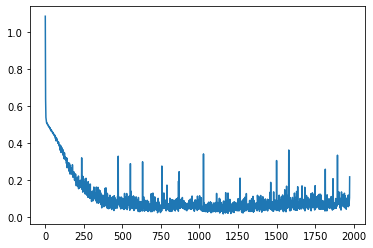

In [ ]:
plt.plot(loss_enc)

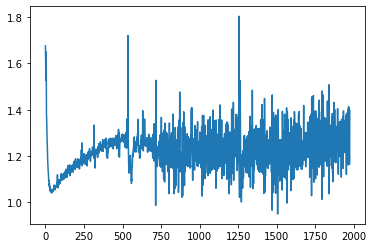

In [ ]:
plt.plot(loss_dec)


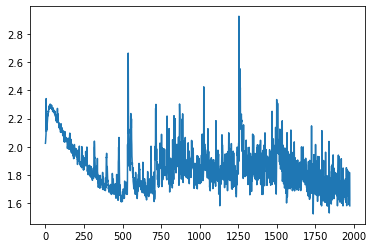

In [ ]:
plt.plot(loss_dis)
